In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error ,r2_score
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.gaussian_process.kernels import Product
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

In [2]:
booking_df = pd.read_csv('Booking_cleaned.csv')

In [3]:
## IQR = Q3 - Q1
## Price
price_q1 , price_q3 = np.percentile(booking_df['Price'],[25,75])
priceIQR = (price_q3 - price_q1)
priceTUK = price_q3 + (1.5 * (priceIQR))

#remove outliers from 'Price'
#CODE HERE
booking_df = booking_df[~(booking_df['Price'] > (priceTUK))]

In [4]:
booking_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40706 entries, 0 to 41003
Data columns (total 47 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Name                                       40706 non-null  object 
 1   NumOfWeekendDays                           40706 non-null  float64
 2   Nights                                     40706 non-null  float64
 3   RoomType                                   40706 non-null  float64
 4   BedType                                    40706 non-null  int64  
 5   Breakfast                                  40706 non-null  int64  
 6   Review                                     40706 non-null  int64  
 7   Rating                                     40706 non-null  float64
 8   Score                                      40706 non-null  float64
 9   Cancellation                               40706 non-null  int64  
 10  CenterDistance        

In [5]:
booking_df_model = booking_df.drop(['Name'],axis = 1)

In [6]:
booking_df_model.describe()

,NumOfWeekendDays,Nights,RoomType,BedType,Breakfast,Review,Rating,Score,Cancellation,CenterDistance,...,Location_Wall Street - Financial District,SnapShotMonth,SnapShotDay,CheckinMonth,CheckinDay,CheckoutMonth,CheckoutDay,TTT,LOS,PricePerNight
count,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,...,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000,40706.000000
mean,0.863362,2.987152,5.154523,5.368005,0.236648,2447.796443,6.691176,7.995553,0.711345,2.298341,...,0.064782,2.666265,10.353854,3.000197,15.864000,3.073748,16.605021,14.894782,3.987152,264.207144
std,0.835874,1.414233,1.213951,0.819569,0.425030,2605.755286,0.747740,0.530146,0.453143,1.766357,...,0.246143,0.471552,11.809611,0.151153,8.419392,0.261364,8.590885,8.354436,1.414233,81.461889
min,0.000000,1.000000,1.000000,2.000000,0.000000,3.000000,5.000000,5.600000,0.000000,0.250000,...,0.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,57.000000
25%,0.000000,2.000000,5.000000,5.000000,0.000000,834.500000,6.000000,7.700000,0.000000,1.200000,...,0.000000,2.000000,1.000000,3.000000,9.000000,3.000000,10.000000,8.000000,3.000000,205.000000
50%,1.000000,3.000000,6.000000,6.000000,0.000000,1447.000000,7.000000,8.100000,1.000000,1.800000,...,0.000000,3.000000,3.000000,3.000000,16.000000,3.000000,17.000000,15.000000,4.000000,254.000000
75%,2.000000,4.000000,6.000000,6.000000,0.000000,3023.000000,7.000000,8.400000,1.000000,2.500000,...,0.000000,3.000000,27.000000,3.000000,23.000000,3.000000,24.000000,22.000000,5.000000,310.000000
max,2.000000,5.000000,7.000000,6.000000,1.000000,14997.000000,10.000000,9.500000,1.000000,7.900000,...,1.000000,3.000000,27.000000,4.000000,31.000000,4.000000,31.000000,29.000000,6.000000,850.000000


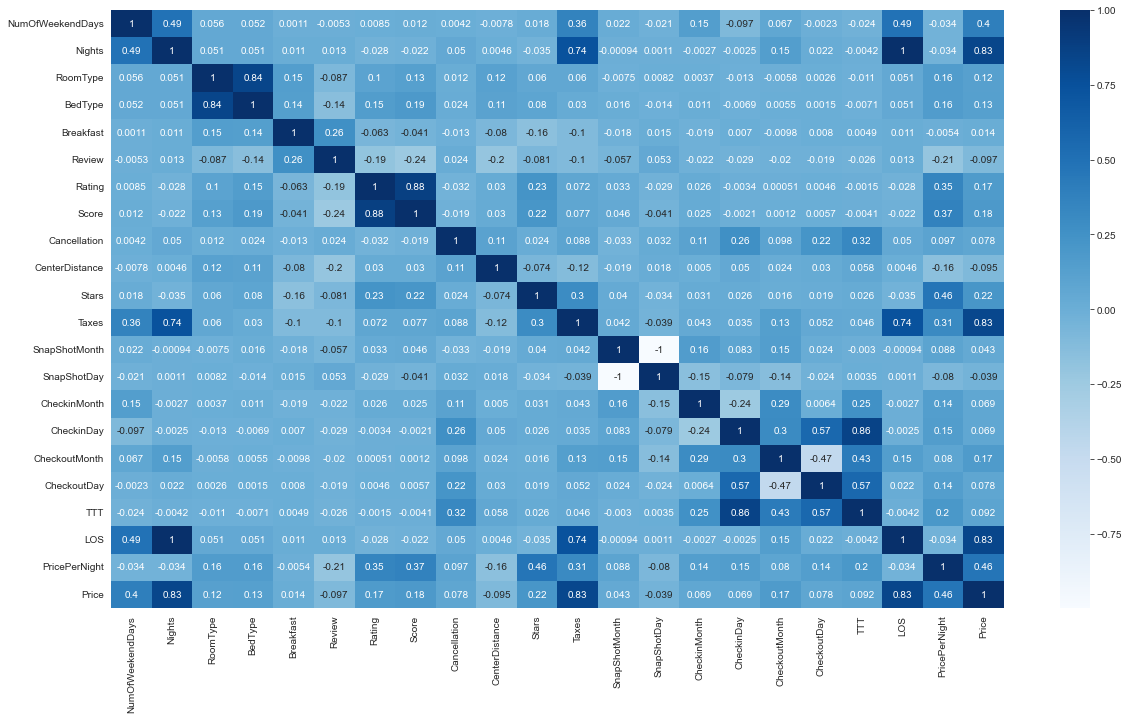

In [7]:
plt.figure(figsize=(20,11))
sns.heatmap(booking_df_model[['NumOfWeekendDays','Nights','RoomType','BedType','Breakfast','Review','Rating',
                             'Score','Cancellation','CenterDistance','Stars','Taxes','SnapShotMonth',
                             'SnapShotDay','CheckinMonth','CheckinDay','CheckoutMonth','CheckoutDay',
                             'TTT','LOS','PricePerNight','Price']].corr(),annot=True,cmap='Blues')
plt.show()

In [8]:
## Columns that can be dropped : Nights , Taxes , BedType , Rating , SnapShotMonth , CheckinDay , LOS

# Genral functions

In [9]:
def residual_scatter(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    plt.figure(figsize=(23,10))
    plt.scatter(y_pred_train,residualsTrain,color='skyblue',marker='.',label='Training Data')
    plt.scatter(y_pred_test,residualsTest,color='navy',marker='.',label='Testing Data')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0,xmin=-300,xmax=2700,color='r')
    plt.show()
    
def residual_hist(y_test,y_pred_test,y_train,y_pred_train):
    residualsTest = y_test - y_pred_test
    residualsTrain = y_train - y_pred_train
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
    sns.distplot(residualsTest,hist=True,kde=True,ax=ax1)
    ax1.title.set_text('Test Residual Distribution')
    sns.distplot(residualsTrain,hist=True,kde=True,ax=ax2)
    ax2.title.set_text('Train Residual Distribution')
    plt.show()
    
def plot_tree(dt):
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (6,6), dpi=500)

    tree.plot_tree(dt,
           feature_names = list(X.columns), 
           filled = True);


# LinearRegression

In [214]:
from sklearn.linear_model import LinearRegression

In [215]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [216]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [217]:
lr = LinearRegression()

In [218]:
lr.fit(X_train,y_train)

LinearRegression()

In [219]:
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

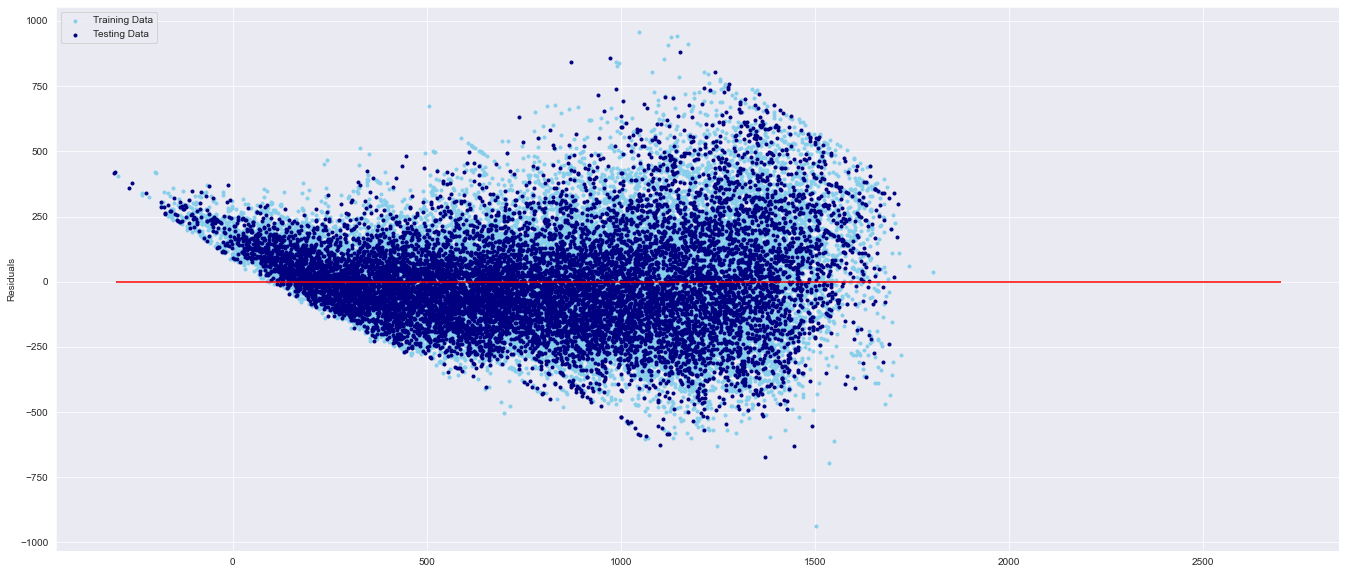

In [149]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

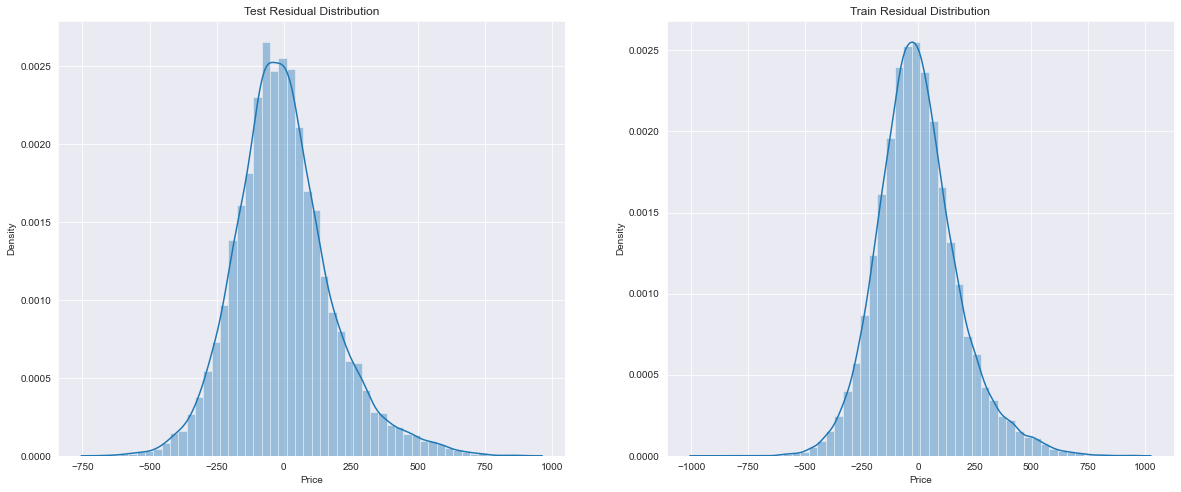

In [150]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [151]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
38784,724,723.586170,0.413830
40382,1271,1104.775184,166.224816
27906,461,884.759764,-423.759764
21733,1143,871.594957,271.405043
3817,272,218.198233,53.801767


In [152]:
lr1_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
lr1_MSE = mean_squared_error(y_test,y_pred_test)
lr1_MAE = mean_absolute_error(y_test,y_pred_test)
lr1_R2 = r2_score(y_test,y_pred_test)

print('RMSE',lr1_RMSE)
print('MSE',lr1_MSE)
print('MAE',lr1_MAE)
print('R2',lr1_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 181.93542669352126
MSE 33100.49948615365
MAE 138.25225298944048
R2 0.8307106023656234
R2 Train 0.8303673593695677


# DecisionTreeRegressor

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [153]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [154]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [155]:
dt = DecisionTreeRegressor()

In [156]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6,7,8,9,10],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [157]:
gs = GridSearchCV(dt, param_grid=param_grid, cv=4, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [159]:
print('dt best param : '  , gs.best_params_)
print('dt best score : '  , gs.best_score_)

dt best param :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5}
dt best score :  0.8888299056780251


In [160]:
dt = DecisionTreeRegressor(**gs.best_params_)

In [161]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=10, max_features='auto', min_samples_leaf=2,
                      min_samples_split=5)

In [162]:
y_pred_test = dt.predict(X_test)
y_pred_train = dt.predict(X_train)

In [163]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head(5)

,Actual Value,Predicted Value,Difference
38784,724,649.511628,74.488372
40382,1271,1490.088235,-219.088235
27906,461,717.007463,-256.007463
21733,1143,979.655172,163.344828
3817,272,289.709779,-17.709779


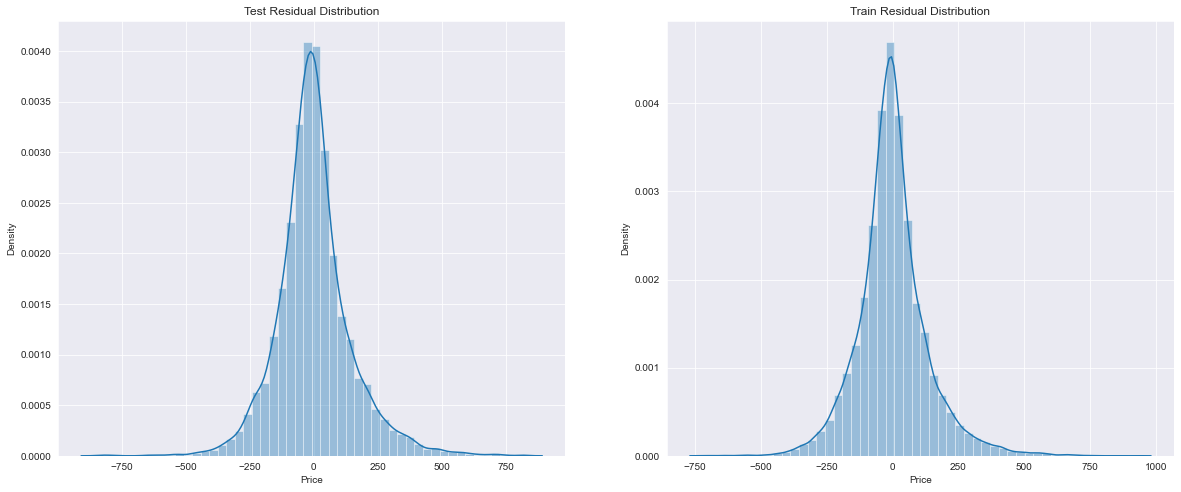

In [164]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [165]:
dt_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
dt_MSE = mean_squared_error(y_test,y_pred_test)
dt_MAE = mean_absolute_error(y_test,y_pred_test)
dt_R2 = r2_score(y_test,y_pred_test)

print('RMSE',dt_RMSE)
print('MSE',dt_MSE)
print('MAE',dt_MAE)
print('R2',dt_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 145.8935511063224
MSE 21284.92825441311
MAE 103.57194467899716
R2 0.8911402323584927
R2 Train 0.906834135946735


# GaussianProcessRegressor

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, RBF, DotProduct, RationalQuadratic, Sum, ExpSineSquared ,ConstantKernel

In [35]:
booking_df2 = booking_df_model[['NumOfWeekendDays','Nights','RoomType','BedType','Breakfast','Review','Rating',
                             'Score','Cancellation','CenterDistance','Stars','Taxes','SnapShotMonth',
                             'SnapShotDay','CheckinMonth','CheckinDay','CheckoutMonth','CheckoutDay',
                             'TTT','LOS','PricePerNight','Price']]

In [36]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(booking_df2), columns=booking_df2.columns)

In [37]:
sample_df = df_normalized.sample(frac=0.25)

In [38]:
sample_df.shape

(10176, 22)

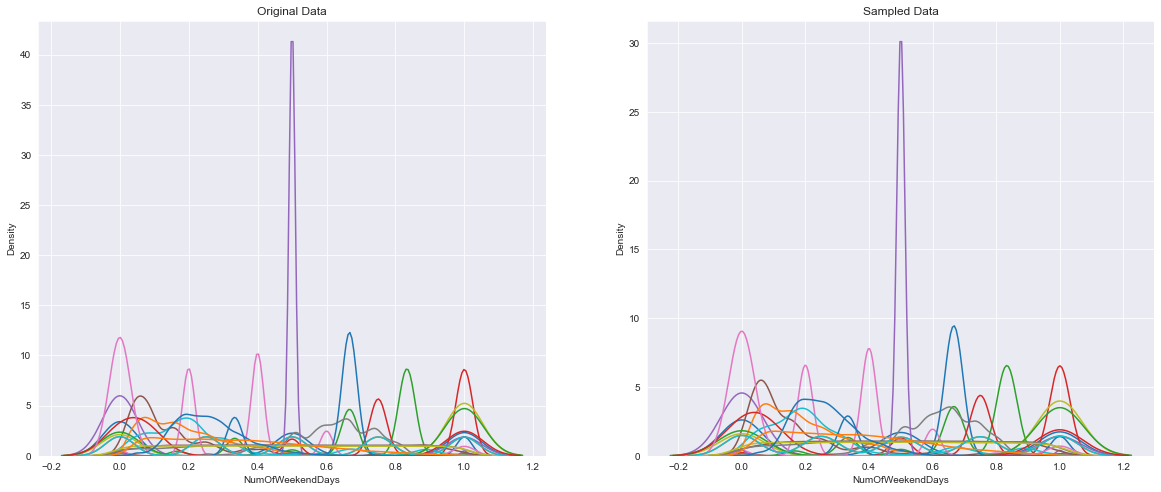

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
for i,col in enumerate(df_normalized[:-1]):
    sns.kdeplot(df_normalized[col],ax=ax1)
for i,col in enumerate(sample_df[:-1]):
    sns.kdeplot(sample_df[col],ax=ax2)
ax1.title.set_text('Original Data')
ax2.title.set_text('Sampled Data')

In [40]:
X = sample_df.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' , 'LOS','PricePerNight'],axis = 1)
y = sample_df.Price

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [42]:
kernels = [Product(DotProduct()+WhiteKernel(),RBF()),
         Product(DotProduct()+WhiteKernel(),Matern())]

In [47]:
param_grid = [{'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
              'kernel__k2__length_scale':[0.8,1.0,1.2]},
             {'kernel__k1__k2__noise_level':[0.2,0.5,0.7],
             'kernel__k2__length_scale':[0.8,1.0,1.2],
             'kernel__k2__nu':[1.5,2.5]}]

In [48]:
kernel.get_params().keys()


dict_keys(['k1', 'k2', 'k1__k1', 'k1__k2', 'k1__k1__sigma_0', 'k1__k1__sigma_0_bounds', 'k1__k2__noise_level', 'k1__k2__noise_level_bounds', 'k2__length_scale', 'k2__length_scale_bounds', 'k2__nu'])

In [ ]:
best_score  = -np.inf
for i,kernel in enumerate(kernels):
    gpr = GaussianProcessRegressor(kernel=kernel)
    gs = GridSearchCV(gpr, param_grid[i], cv=5,verbose=5)
    gs.fit(X_train,y_train)
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_kernel = gs.best_estimator_.kernel_

In [51]:
print('Best kernel is : ',best_kernel)
print('Score : ',best_score)

Best kernel is :  DotProduct(sigma_0=0.0356) + WhiteKernel(noise_level=0.00459) * Matern(length_scale=5.59, nu=1.5)
Score :  0.8793292110498975


In [56]:
gpr = GaussianProcessRegressor(kernel=best_kernel)

In [64]:
with tqdm(total=100) as pbar:
    for i in range(100):
        gpr.fit(X_train, y_train)
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [4:53:31<00:00, 176.12s/it]


In [65]:
y_pred_train, y_pred_tr_std = gpr.predict(X_train, return_std=True)
y_pred_test, y_pred_te_std = gpr.predict(X_test, return_std=True)

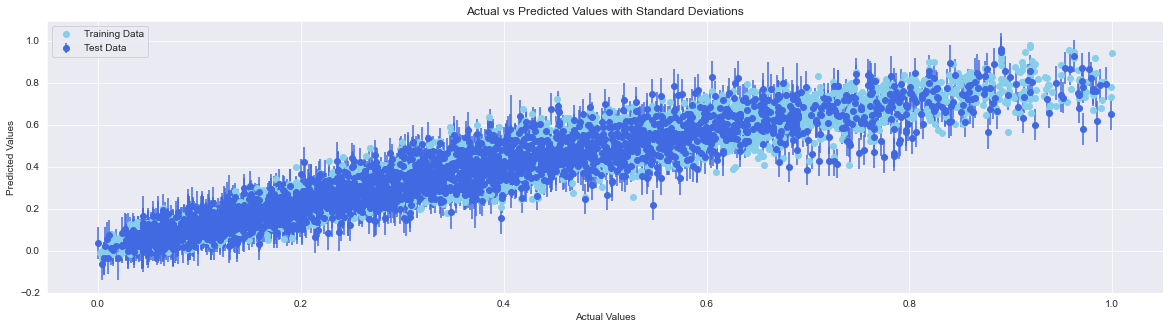

In [74]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.errorbar(y_test, y_pred_test, yerr=y_pred_te_std, fmt='o', color='royalblue', label='Test Data')
ax.plot(y_train, y_pred_train, 'o', color='skyblue', label='Training Data')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values with Standard Deviations')
ax.legend()

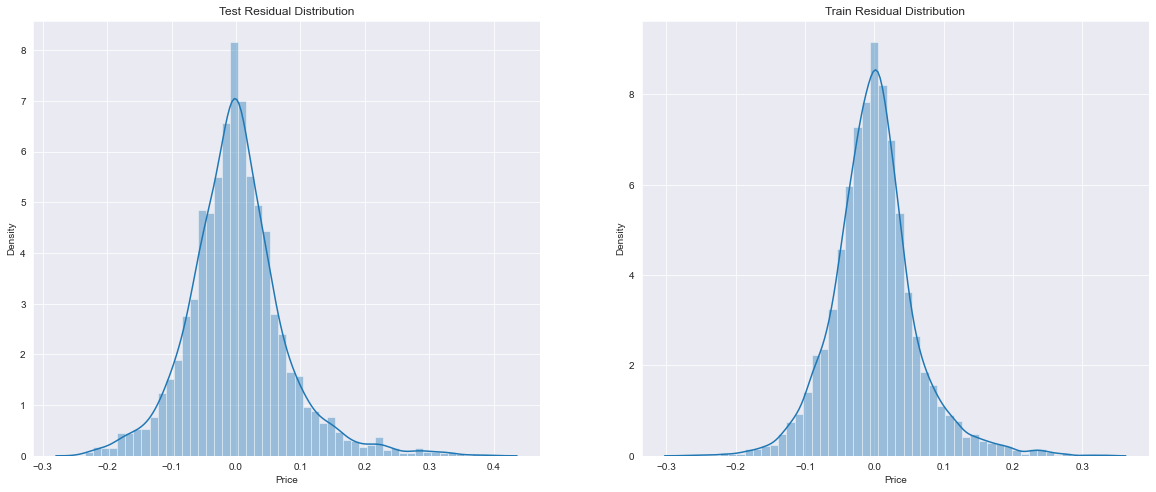

In [67]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [68]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
6917,0.506726,0.531017,-0.024290
25696,0.187843,0.189229,-0.001386
20475,0.117090,0.086348,0.030742
2915,0.078226,0.043821,0.034405
22227,0.697559,0.779668,-0.082110


In [69]:
gpr_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
gpr_MSE = mean_squared_error(y_test,y_pred_test)
gpr_MAE = mean_absolute_error(y_test,y_pred_test)
gpr_R2 = r2_score(y_test,y_pred_test)

print('RMSE',gpr_RMSE)
print('MSE',gpr_MSE)
print('MAE',gpr_MAE)
print('R2',gpr_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 0.0751713336778126
MSE 0.005650729406901043
MAE 0.054234355230889514
R2 0.881535106696707
R2 Train 0.9225909142919656



# ElasticNet

In [75]:
from sklearn.linear_model import ElasticNet

In [166]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [167]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [168]:
en = ElasticNet()

In [169]:
param_grid = {
    'alpha': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.25, 0.5, 0.75],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 5000, 10000],
}

In [171]:
gs = GridSearchCV(en, param_grid=param_grid, cv=3, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [173]:
print('en best param : '  , gs.best_params_)
print('en best score : '  , gs.best_score_)

en best param :  {'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.75, 'max_iter': 1000, 'normalize': False}
en best score :  0.8286984075749521


In [174]:
en = ElasticNet(**gs.best_params_)

In [175]:
with tqdm(total=100) as pbar:
    for i in range(100):
        en.fit(X_train, y_train)
        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


In [176]:
y_pred_test = en.predict(X_test)
y_pred_train = en.predict(X_train)

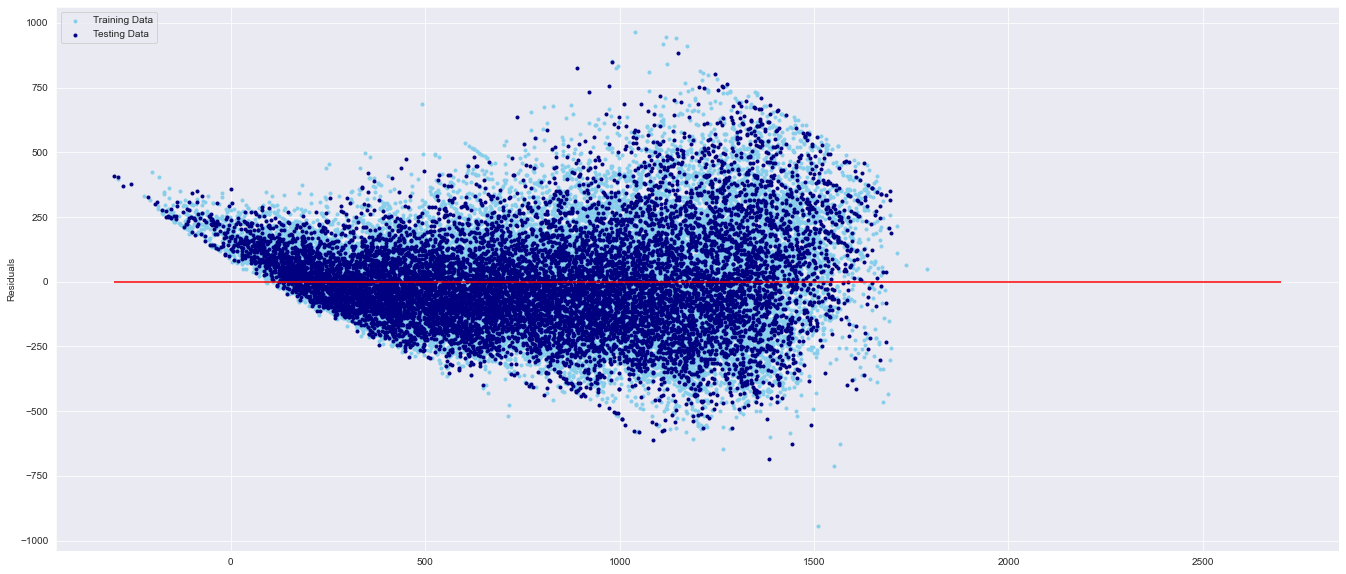

In [177]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

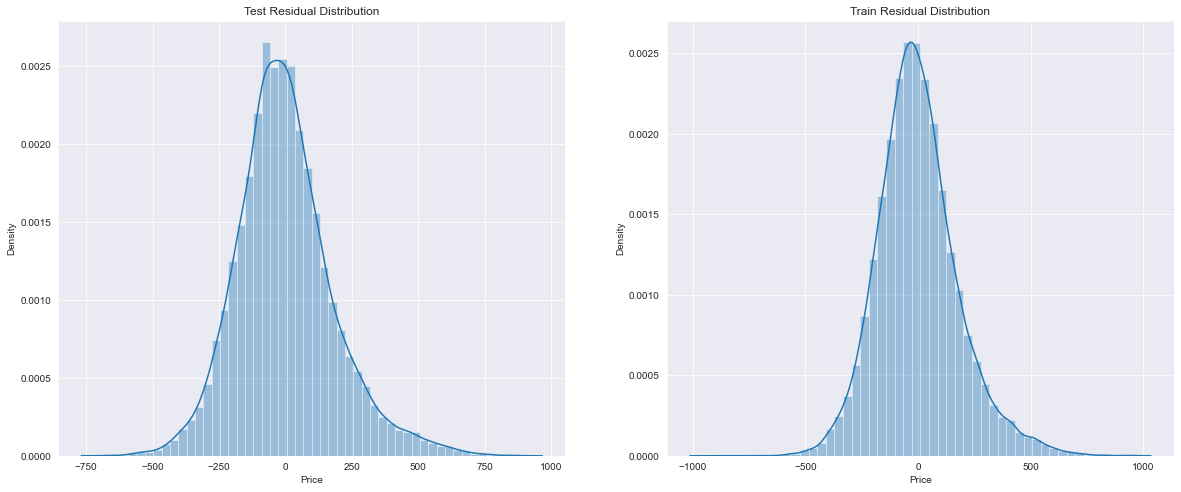

In [178]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [179]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
38784,724,718.141645,5.858355
40382,1271,1103.741639,167.258361
27906,461,876.029829,-415.029829
21733,1143,878.676684,264.323316
3817,272,233.141591,38.858409


In [180]:
es_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
es_MSE = mean_squared_error(y_test,y_pred_test)
es_MAE = mean_absolute_error(y_test,y_pred_test)
es_R2 = r2_score(y_test,y_pred_test)

print('RMSE',es_RMSE)
print('MSE',es_MSE)
print('MAE',es_MAE)
print('R2',es_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 182.75202265996614
MSE 33398.30178630878
MAE 138.7423620459883
R2 0.8291875204547754
R2 Train 0.8290460112004104


# RandomForestRegressor

In [187]:
from sklearn.ensemble import RandomForestRegressor

In [188]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [189]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [190]:
rf = RandomForestRegressor()

In [191]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [8,9,10],
    'min_samples_split': [2,3,4, 5],
    'min_samples_leaf': [2, 4,5],
    'max_features': ['sqrt', 'log2', None]  
}

In [192]:
gs = GridSearchCV(rf, param_grid=param_grid, cv=3, verbose= 5)

In [ ]:
gs.fit(X_train,y_train)

In [194]:
print('rf best param : '  , gs.best_params_)
print('rf best score : '  , gs.best_score_)

rf best param :  {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
rf best score :  0.9114714782025453


In [195]:
rf = RandomForestRegressor(**gs.best_params_)

In [196]:
with tqdm(total=100) as pbar:
    for i in range(100):
        rf.fit(X_train, y_train)
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [1:08:00<00:00, 40.80s/it]


In [197]:
y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

In [198]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
38784,724,644.582046,79.417954
40382,1271,1306.397119,-35.397119
27906,461,717.728392,-256.728392
21733,1143,969.550620,173.449380
3817,272,263.453998,8.546002


In [199]:
rf_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
rf_MSE = mean_squared_error(y_test,y_pred_test)
rf_MAE = mean_absolute_error(y_test,y_pred_test)
rf_R2 = r2_score(y_test,y_pred_test)

print('RMSE',rf_RMSE)
print('MSE',rf_MSE)
print('MAE',rf_MAE)
print('R2',rf_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 130.4590172035169
MSE 17019.555169707517
MAE 93.09202772810355
R2 0.912955082629793
R2 Train 0.9238508966663743


# XGBoostRegressor

In [116]:
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space.space import Real ,Categorical,Integer
from xgboost import plot_importance

In [117]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' , 'LOS','PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [118]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=0)

In [119]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBRegressor())
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_pa

In [120]:
search_space = {
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.001,1.0,prior='log-uniform'),
    'clf__subsample':Real(0.5,1.0),
    'clf__colsample_bytree':Real(0.5,1.0),
    'clf__colsample_bylever':Real(0.5,1.0),
    'clf__colsample_bynode':Real(0.5,1.0),
    'clf__reg_alpha':Real(0.0,10.0),
    'clf__reg_lamda':Real(0.0,10.0),
    'clf__gamma':Real(0.0,10.0)
    
}

opt = BayesSearchCV(pipe,search_space,cv=3,n_iter=10,scoring='r2',random_state=8)

In [ ]:
opt.fit(X_train,y_train)

In [122]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None,
                              colsample_bylever=0.6854728136721551,
                              colsample_bynode=0.9716292421559054,
                              colsample_bytree=0.9999681720272138,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.2693427...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.4165635668761467, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth

In [123]:
y_pred_test = opt.predict(X_test)
y_pred_train = opt.predict(X_train)

In [124]:
opt.best_estimator_.steps

[('encoder', TargetEncoder(cols=[])),
 ('clf',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bylever=0.6854728136721551,
               colsample_bynode=0.9716292421559054,
               colsample_bytree=0.9999681720272138, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=9.269342703724346, gpu_id=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.4165635668761467, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, ...))]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

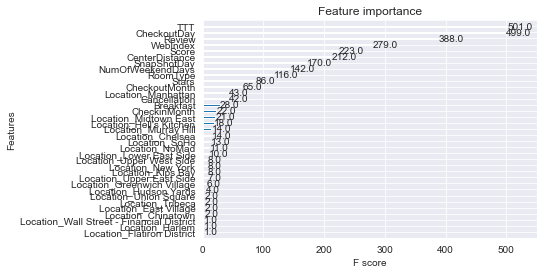

In [125]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

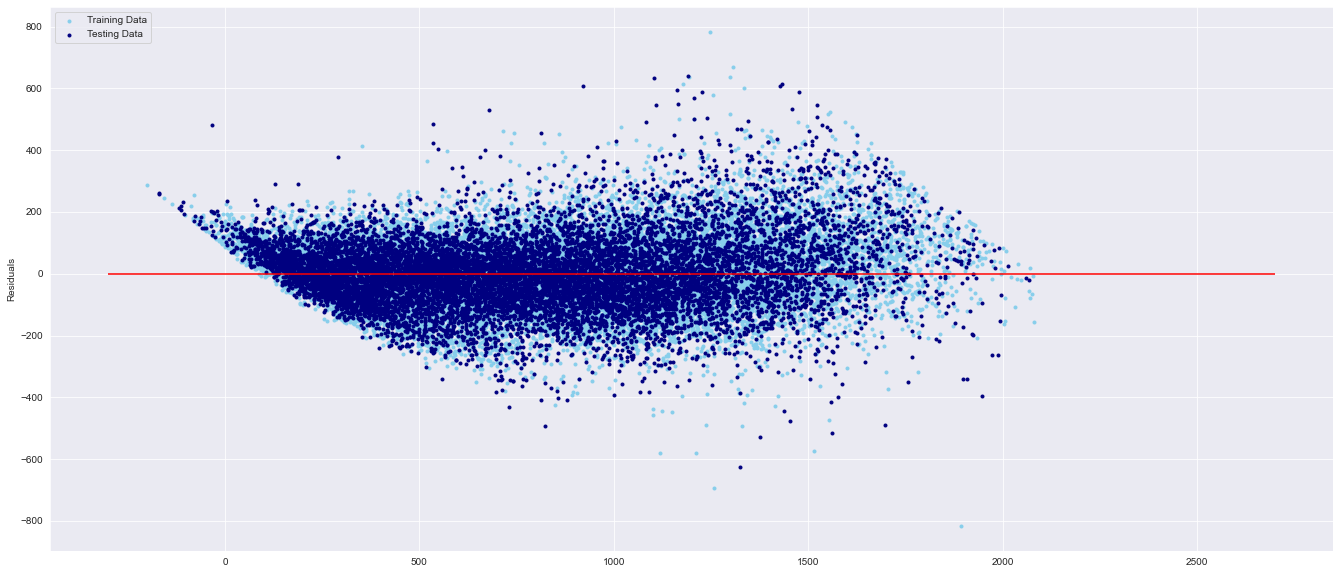

In [126]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

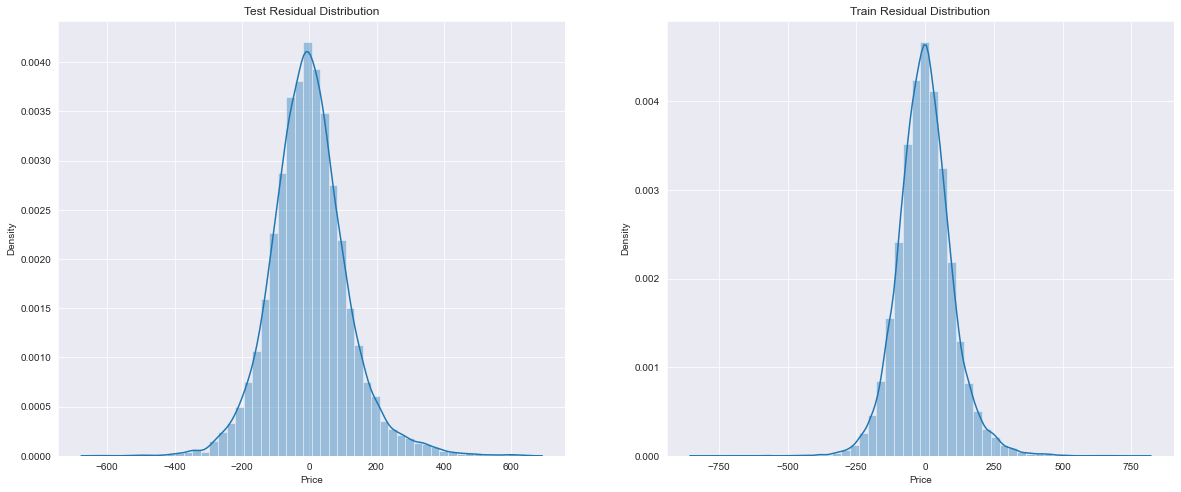

In [127]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [128]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
38784,724,835.868530,-111.868530
40382,1271,1350.427246,-79.427246
27906,461,661.838318,-200.838318
21733,1143,1243.712036,-100.712036
3817,272,445.021484,-173.021484


In [129]:
opt_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
opt_MSE = mean_squared_error(y_test,y_pred_test)
opt_MAE = mean_absolute_error(y_test,y_pred_test)
opt_R2 = r2_score(y_test,y_pred_test)

print('RMSE',opt_RMSE)
print('MSE',opt_MSE)
print('MAE',opt_MAE)
print('R2',opt_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 114.51496829446279
MSE 13113.677963481818
MAE 85.66587595549366
R2 0.932931324974788
R2 Train 0.9476298224247302


## Models summary

In [200]:
models = pd.DataFrame({'Model' : ['LinearRegression' ,  'DecisionTree' ,
                                  'GPR','ElasticNet',
                                 'RandomForestRegressor','XGBoost'],
                      'RMSE' : [lr1_RMSE , dt_RMSE,gpr_RMSE,es_RMSE,rf_RMSE,opt_RMSE],
                      'MSE' : [lr1_MSE , dt_MSE,gpr_MSE,es_MSE,rf_MSE,opt_MSE],
                      'MAE' : [lr1_MAE , dt_MAE,gpr_MAE,es_MAE,rf_MAE,opt_MAE],
                      'R2' : [lr1_R2 , dt_R2,gpr_R2,es_R2,rf_R2,opt_R2]})

In [201]:
models.sort_values(by = 'R2', ascending = False)

,Model,RMSE,MSE,MAE,R2
5,XGBoost,114.514968,13113.677963,85.665876,0.932931
4,RandomForestRegressor,130.459017,17019.555170,93.092028,0.912955
1,DecisionTree,145.893551,21284.928254,103.571945,0.891140
2,GPR,0.075171,0.005651,0.054234,0.881535
0,LinearRegression,181.935427,33100.499486,138.252253,0.830711
3,ElasticNet,182.752023,33398.301786,138.742362,0.829188


# Experiment with the best scoring model - XGBoost

### In this experiment we will check if it is possible to predict the price of the hotel while taking TTT <= 25 and to predict the price for TTT > 25

In [202]:
X = booking_df_model.drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'],axis = 1)
y = booking_df_model['Price']

In [203]:
X_train = booking_df_model[booking_df_model['TTT'] <= 25].drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'], axis=1)
y_train = booking_df_model[booking_df_model['TTT'] <= 25]['Price']
X_test = booking_df_model[booking_df_model['TTT'] > 25].drop(['Price','Nights','Taxes' , 'BedType' , 'Rating' , 'SnapShotMonth' , 'CheckinDay' ,'PricePerNight'], axis=1)
y_test = booking_df_model[booking_df_model['TTT'] > 25]['Price']

In [204]:
estimators = [
    ('encoder',TargetEncoder()),
    ('clf',XGBRegressor())
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_pa

In [205]:
search_space = {
    'clf__max_depth':Integer(2,8),
    'clf__learning_rate':Real(0.001,1.0,prior='log-uniform'),
    'clf__subsample':Real(0.5,1.0),
    'clf__colsample_bytree':Real(0.5,1.0),
    'clf__colsample_bylever':Real(0.5,1.0),
    'clf__colsample_bynode':Real(0.5,1.0),
    'clf__reg_alpha':Real(0.0,10.0),
    'clf__reg_lamda':Real(0.0,10.0),
    'clf__gamma':Real(0.0,10.0)
    
}

opt = BayesSearchCV(pipe,search_space,cv=3,n_iter=10,scoring='r2',random_state=8)

In [ ]:
opt.fit(X_train,y_train)

In [207]:
y_pred_test = opt.predict(X_test)
y_pred_train = opt.predict(X_train)

In [208]:
opt.best_estimator_

Pipeline(steps=[('encoder', TargetEncoder(cols=[])),
                ('clf',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None,
                              colsample_bylever=0.6854728136721551,
                              colsample_bynode=0.9716292421559054,
                              colsample_bytree=0.9999681720272138,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=9.2693427...
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.4165635668761467, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

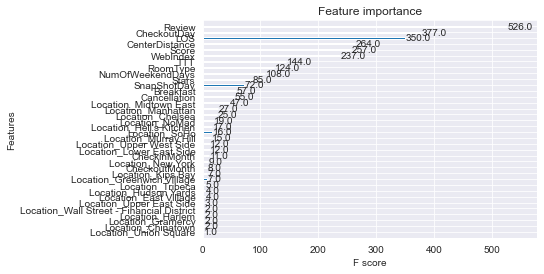

In [209]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
plot_importance(xgboost_model)

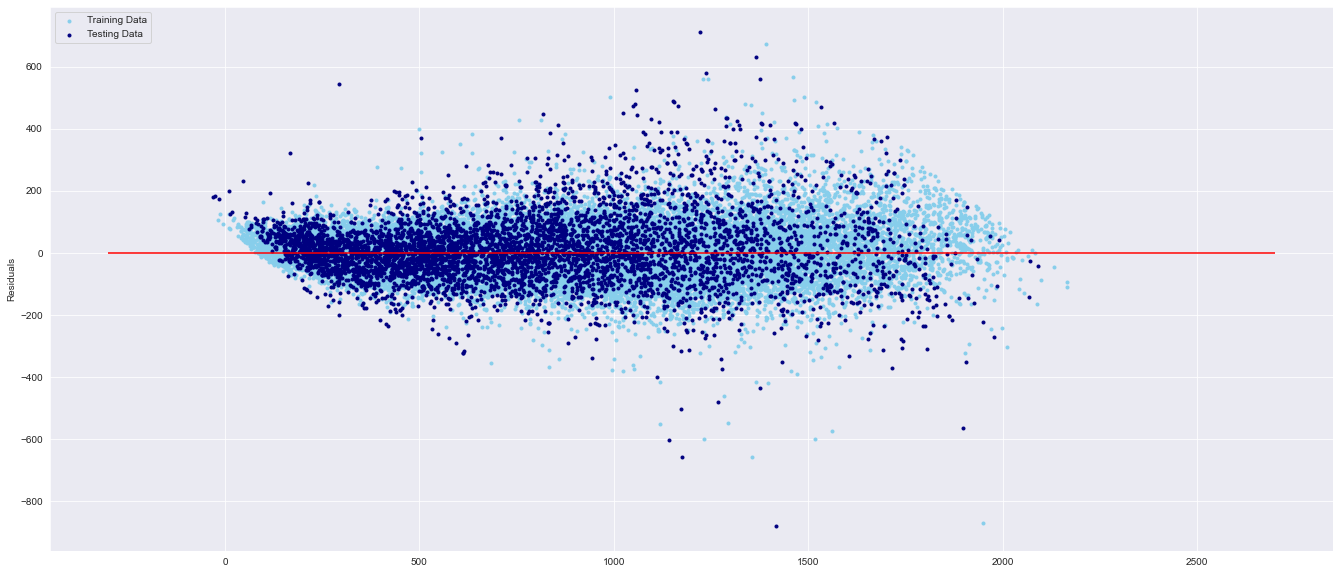

In [210]:
residual_scatter(y_test,y_pred_test,y_train,y_pred_train)

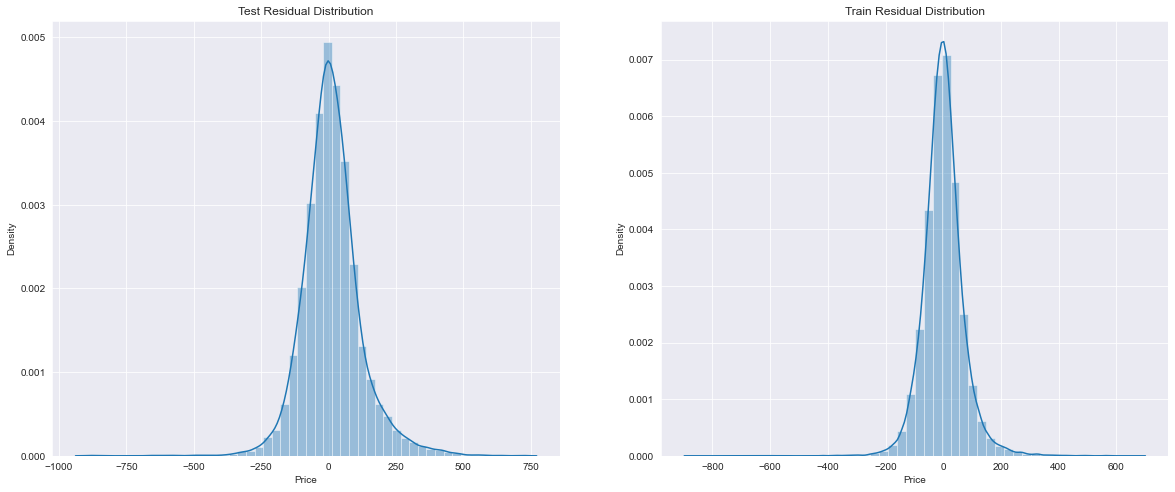

In [211]:
residual_hist(y_test,y_pred_test,y_train,y_pred_train)

In [212]:
pred_y_df = pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred_test,'Difference':y_test - y_pred_test})
pred_y_df.head()

,Actual Value,Predicted Value,Difference
11650,239,209.225830,29.774170
11651,216,226.911438,-10.911438
11652,140,165.674698,-25.674698
11653,218,324.634766,-106.634766
11654,149,18.265291,130.734709


In [213]:
opt1_RMSE = np.sqrt(mean_squared_error(y_test,y_pred_test))
opt1_MSE = mean_squared_error(y_test,y_pred_test)
opt1_MAE = mean_absolute_error(y_test,y_pred_test)
opt1_R2 = r2_score(y_test,y_pred_test)

print('RMSE',opt1_RMSE)
print('MSE',opt1_MSE)
print('MAE',opt1_MAE)
print('R2',opt1_R2)
print('R2 Train' , r2_score(y_train,y_pred_train))

RMSE 109.57356975061035
MSE 12006.36718789187
MAE 78.32719107541487
R2 0.9382851923862018
R2 Train 0.9746494095641265
